![](https://www.math.unipd.it/~marcuzzi/BannerStrumentifondamentali.png)

# Scrivere i kernel CUDA: il decoratore @cuda.jit

Il modulo numba.cuda permette di scrivere kernel CUDA interamente in linguaggio Python, traducendolo in linguaggio CUDA/C alla prima chiamata. 

Numba fornisce il decoratore cuda.jit che permette di generare kernel CUDA. In pratica, traduce il codice Python in codice PTX che viene eseguito sulla GPU. I kernel vengono scritti seguento il modello di esecuzione CUDA in linguaggio Python.


## Modello di esecuzione CUDA

  -  Funzioni kernel
       - vengono chiamate dalla CPU ed eseguite sulla GPU
       - non possono tornare nessun valore, gli output sono dati come argomenti in input

  -  Griglie
       - insiemi di blocchi
       - 1D, 2D, 3D
  -  Blocchi
       - insiemi di threads
       - 1D, 2D, 3D
  -  Ogni kernel esegue lo stesso codice (il kernel)
      - i threads usano le coordinate di griglie, blocchi e thread per determinare il proprio indice assoluto in memoria

Gli step principali sono:
- Definire il kernel
- Allocare lo spazio in memoria sulla CPU per i vettori da sommare e per il vettore soluzione
- Copiare i vettori sulla GPU (OPZIONALE)
- Chiamare il kernel specificando la dimensione di blocchi e griglie
- Copiare il risultato sulla CPU (OPZIONALE)

In [1]:
import matplotlib.pyplot as plt
import math
from numba import cuda
import numpy as np
from timeit import default_timer

# I kernel 1D

Scriviamo un kernel che calcoli la somma di due vettori $a,b$

$$ c[i] = a[i] + b[i], \quad i=1,...,n.$$
Notiamo che, fissato $i$, la somma $c[i] = a[i] + b[i]$ è indipendende da tutte le altre, e tutti gli elementi di $c$ possono essere processati in parallelo.
È perciò naturale assegnare ogni somma $c[i] = a[i] + b[i]$ ad un thread (il thread $i$-esimo).

Per determinare il proprio indice, i thread utilizzano una serie di direttive CUDA che hanno senso solo all'interno di un kernel CUDA. 

In [2]:
@cuda.jit
def sum1d(a, b, c):
    tx = cuda.threadIdx.x # indice del thread nel blocco
    bx = cuda.blockIdx.x  # indice del blocco nella griglia
    bw = cuda.blockDim.x  # numero di threads per blocco
    i = tx + bx * bw # indice del thread nella griglia
    
    if i < c.size:
        c[i] = a[i] + b[i]
    #endif
    return

## Il codice nel dettaglio

- Definiamo un kernel CUDA con tre argomenti

        @cuda.jit
        def sum1d(a,b,c):

- Individuiamo l'indice globale di ogni thread

        tx = cuda.threadIdx.x # indice del thread nel blocco
        bx = cuda.blockIdx.x  # indice del blocco nella griglia
        bw = cuda.blockDim.x  # numero di threads per blocco
        i = tx + bx * bw # indice del thread nella griglia

    oppure, in maniera piu' semplificata:

        i = cuda.grid(1)

- Ci assicuriamo che l'indice globale non ecceda la dimensione degli array
        if i < c.size:

- Il lavoro effettivo

        c[i] = a[i] + b[i]



## Generazione dei dati

In [3]:
# Generazione dei dati
n = 100
a = np.arange(n, dtype=np.float32)
b = np.arange(n, dtype=np.float32)
c = np.empty_like(a)                 # L'array nel quale scrivere il risultato va dichiarato prima della chiamata

## Calcolare la dimensione della griglia 

  - Solitamente la dimensione dei blocchi (`threads_per_block`) viene scelta come un multiplo di 32 (questo perchè i thread vengono fisicamente eseguiti in gruppi di 32 chiamati *warp*).

  -  Il numero totale di blocchi della griglia è `ceil(n/threads_per_block)`

Nota: In questo modo il numero di thread lanciati è più grande del numero di elementi nell'array

In [4]:
threads_per_block = 128
blocks_per_grid= int(math.ceil(float(n) / threads_per_block))

print("Threads per block:", threads_per_block)
print("Blocks per grid:", blocks_per_grid)

Threads per block: 128
Blocks per grid: 1


## Chiamare il kernel

Gli oggetti kernel usano __getitem__ (indexing notation) per configurare la dimensione di blocchi e griglie.

    kernel_function[griddim, blockdim](*args)

  -  griddim
        Numero di blocchi nella griglia (grid dimension)
        type: int per 1d o 1,2,3-tuple di int per 1d, 2d, o 3d rispettivamente

  -  blockdim:
        Numero di threads per blocco (blockdim dimension)
        type: int per 1d o 1,2,3-tuple di int per 1d, 2d, o 3d rispettivamente



In [5]:
sum1d[blocks_per_grid, threads_per_block](a, b, c)    # L'ultimo argomento e' l'output in questo caso
print(c)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198.]


In [6]:
print(sum1d.inspect_types())

_ZN6cudapy8__main__9sum1d$241E5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE5ArrayIfLi1E1C7mutable7alignedE (array(float32, 1d, C), array(float32, 1d, C), array(float32, 1d, C))
--------------------------------------------------------------------------------
# File: <ipython-input-2-8949440c4290>
# --- LINE 1 --- 
# label 0

@cuda.jit

# --- LINE 2 --- 

def sum1d(a, b, c):

    # --- LINE 3 --- 
    #   a = arg(0, name=a)  :: array(float32, 1d, C)
    #   b = arg(1, name=b)  :: array(float32, 1d, C)
    #   c = arg(2, name=c)  :: array(float32, 1d, C)
    #   $0.1 = global(cuda: <module 'numba.cuda' from '/usr/local/lib/python3.5/dist-packages/numba/cuda/__init__.py'>)  :: Module(<module 'numba.cuda' from '/usr/local/lib/python3.5/dist-packages/numba/cuda/__init__.py'>)
    #   $0.2 = getattr(attr=threadIdx, value=$0.1)  :: Module(<class 'numba.cuda.stubs.threadIdx'>)
    #   del $0.2
    #   del $0.1
    #   $0.3 = call tid.x(vararg=None, func=tid.x, args=(), kws=()) 

Vediamo che le informazioni generate dal compilatore Numba sono molte. Notiamo la segnatura della funzione che viene automaticamente dedotta dal tipo di dato che riceve il kernel:

`(array(float32, 1d, C), array(float32, 1d, C), array(float32,

1d, C))`.

Gli input sono tre array 1-dimensionali di tipo float32 salvati in memoria nell'ordine del linguaggio C, cioè per colonne (in questo caso gli array 1d sono visti come vettori colonna). Numba utilizzerà questa segnatura se il kernel verrà chiamato ancora con un tipo di dato meno inclusivo (ad es. `int32`), altrimenti genererà un'altra funzione compilata (ad es. `float64`).

Se continuiamo a scorrere le informazioni notiamo che Numba tipizza ogni variabile dichiarata all'interno del kernel.

# I kernel 2D

Scriviamo un kernel che calcoli la somma di due matrici della stessa dimensione $A,B$

$$ C[i,j] = A[i,j] + B[i,j], \quad i=1,...,n, \ j = 1,...,m.$$

Notiamo che, come prima, fissati $i$ e $j$, il calcolo di $C[i,j]$ è indipendende da dutti gli altri elementi della matrice $C$, che possono quindi essere processati in parallelo.

Assegnamo perciò il calcolo di  $C[i,j]$ al thread di indice $(i,j)$.

In [7]:
@cuda.jit
def sum2d(A, B, C):
    tx = cuda.threadIdx.x # indice riga del thread all'interno del proprio blocco 2D
    ty = cuda.threadIdx.y # indice colonna del thread all'interno del proprio blocco 2D
    bx = cuda.blockIdx.x  # indice riga del blocco all'interno della griglia 2D
    by = cuda.blockIdx.y  # indice colonna del blocco all'interno della griglia 2D

    block_size_x = cuda.blockDim.x  # numero di righe per blocco
    block_size_y = cuda.blockDim.y  # numero di colonne per blocco

    # Indice globale del thread all'interno della griglia di esecuzione
    # Equivalente a i,j = cuda.grid(2)
    i = tx + bx * block_size_x
    j = ty + by * block_size_y
    
    if (i < C.shape[0]) and (j < C.shape[1]):
        C[i,j] = A[i,j] + B[i,j]
    #endif
    return 

In [8]:
A = np.random.rand(n,n).astype(np.float32)
B = np.random.rand(n,n).astype(np.float32)

C = np.zeros_like(A)

In [9]:
threadsperblock = (32, 32)
blockspergrid_x = math.ceil(C.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(C.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [10]:
sum2d[blockspergrid, threadsperblock](A, B, C)

In [11]:
# Verifica del risultato
print(np.linalg.norm(C-(A+B)))

0.0


# Applicazione al rendering di immagini

Scriviamo una funzione `dist2d` che calcola da distanza tra un punto del piano fissato e ogni punto di una griglia 2D di punti equispaziati. Identificando ogni punto della griglia con un pixel la cui intensità è data dalla distanza rispetto al punto $P$. L'intensità di un pixel è indipendente da tutti gli altri, perciò questo calcolo si addice perfettamente al calcolo parallelo.

Scegliamo $P = (0.75, 0.5)$ e definiamo una griglia equispaziata nel quadrato unitario $[0,1] \times [0,1]$ scegliendo $768$ punti in ogni direzione:

$$ P_{ij} = (x_i, y_j), \quad 0 \leq i,j, < 768. $$

Calcoliamo prima l'immagine in seriale.

In [12]:
def distance(x1, x2):
    return math.sqrt((x1[0]-x2[0])*(x1[0]-x2[0])+(x1[1]-x2[1])*(x1[1]-x2[1]))

def dist2d(xmin, xmax, ymin, ymax, img_width, img_height, p):
    x = np.linspace(xmin, xmax, img_width)
    y = np.linspace(ymin, ymax, img_height)
    img = np.empty((img_width,img_height))
    for i in range(img_width):
        for j in range(img_height):
            img[i,j] = distance([x[i],y[j]], p)
        #endfor
    #endfor
    return img

In [13]:
def dist2d_image(img, xmin, xmax, ymin, ymax):
    dpi = 72
    width  = img.shape[0] / dpi 
    height = img.shape[1] / dpi
    
    fig, ax = plt.subplots(figsize=(width, height), dpi = 72)
    ax.imshow(img.T, extent=[xmin, xmax, ymin, ymax])
    
    return

In [14]:
xmin = 0.0
xmax = 1.0
ymin = 0.0
ymax = 1.0
img_width  = 768
img_height = 768
p = [0.75, 0.5]

img_cpu = dist2d(xmin,xmax,ymin,ymax,img_width,img_height,p)

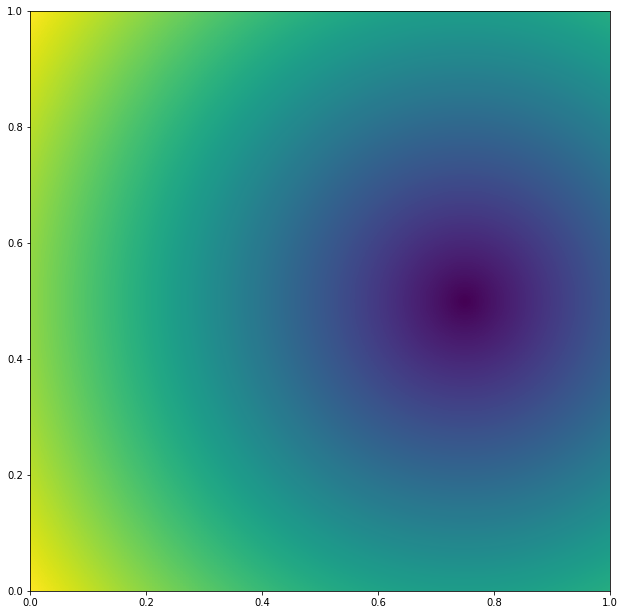

In [15]:
dist2d_image(img_cpu, xmin, xmax, ymin, ymax)

> Una **funzione device** è una funzione che può essere chiamata esclusivamente dalla GPU, quindi all'interno di un kernel. Una funzione device può essere dichiarata tramite il decoratore cuda.jit specificando tra gli argomenti `device = True`. Le funzioni device nella versione attuale di Numba non supportano array, ma solo scalari.

In [16]:
@cuda.jit(device = True)
def distance_dev(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2))

@cuda.jit()
def dist2d_kernel(xmin, xmax, ymin, ymax, px, py, img):
    # Indice globale del thread all'interno della griglia di esecuzione
    i, j = cuda.grid(2)
    
    if (i < img.shape[1]) and (j < img.shape[0]):
        x = xmin + (xmax - xmin)/img_width*i
        y = ymin + (ymax - ymin)/img_height*j
        img[i,j] = distance_dev(px, py, x, y)
    #endif
    return 

In [17]:
img_gpu = np.empty((img_width,img_height))

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(img_gpu.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(img_gpu.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

dist2d_kernel[blockspergrid, threadsperblock](xmin,xmax,ymin,ymax,p[0], p[1], img_gpu)

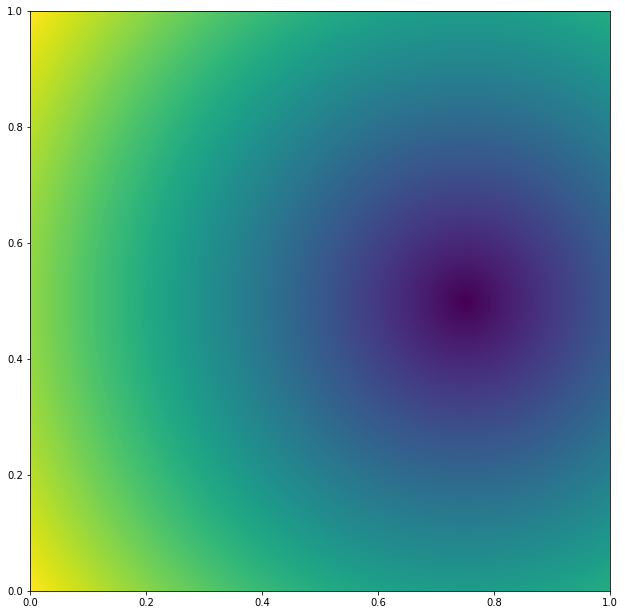

In [18]:
dist2d_image(img_gpu, xmin, xmax, ymin, ymax)

In [19]:
t_i = default_timer()
img_cpu = dist2d(xmin,xmax,ymin,ymax,img_width,img_height,p)
t_f = default_timer()
cpu_time = t_f - t_i

t_i = default_timer()
dist2d_kernel[blockspergrid, threadsperblock](xmin,xmax,ymin,ymax,p[0], p[1], img_gpu)
cuda.synchronize()
t_f = default_timer()
gpu_time = t_f - t_i

print('speed-up = ', cpu_time/gpu_time)

speed-up =  245.19173981949166
